In [1]:
# Standard Imports
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Performance
from time import time

In [3]:
# Machine Learning
from sklearn.linear_model import LogisticRegression

In [4]:
# Helper
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.grid_search import GridSearchCV

# Preliminaries

In [5]:
# Load the Data
train = pd.read_csv('input/train2.csv')
test = pd.read_csv('input/test2.csv')

In [6]:
train.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Gender,Port,AgeFill,FareFill
0,1,0,3,1,0,1,0,22,7.2500
1,2,1,1,1,0,0,1,38,71.2833
2,3,1,3,0,0,0,0,26,7.9250
3,4,1,1,1,0,0,0,35,53.1000
4,5,0,3,0,0,1,0,35,8.0500


# Feature engineering
Insights pulled from visualization and exploration notebook

In [7]:
def createNewCol(boolx):
    featx = []
    for i in range(len(boolx)):
        if boolx[i]:
            featx.append(1) 
        else:
            featx.append(0) 

    return featx

In [8]:
# (1) children younger than 18 in the first or second class predominantly survive
bool1 = (train['AgeFill'] < 18) & (train['Pclass'] < 3)
bool1t = (test['AgeFill'] < 18) & (test['Pclass'] < 3)
print(sum(bool1))

train["kidHighClass"] = createNewCol(bool1)
test["kidHighClass"] = createNewCol(bool1t)

35


In [9]:
# (2) mother's with one child in first or second class predominantly survive
bool2 = (train['AgeFill'] > 18) & (train['Parch'] == 1) & (train['Pclass'] < 3) & (train['Gender'] == 0)
bool2t = (test['AgeFill'] > 18) & (test['Parch'] == 1) & (test['Pclass'] < 3) & (test['Gender'] == 0)
print(sum(bool2))

train["momHighClass"] = createNewCol(bool2)
test["momHighClass"] = createNewCol(bool2t)

26


In [10]:
train[0:20]

,PassengerId,Survived,Pclass,SibSp,Parch,Gender,Port,AgeFill,FareFill,kidHighClass,momHighClass
0,1,0,3,1,0,1,0,22.0,7.2500,0,0
1,2,1,1,1,0,0,1,38.0,71.2833,0,0
2,3,1,3,0,0,0,0,26.0,7.9250,0,0
3,4,1,1,1,0,0,0,35.0,53.1000,0,0
4,5,0,3,0,0,1,0,35.0,8.0500,0,0
5,6,0,3,0,0,1,2,25.0,8.4583,0,0
6,7,0,1,0,0,1,0,54.0,51.8625,0,0
7,8,0,3,3,1,1,0,2.0,21.0750,0,0
8,9,1,3,0,2,0,0,27.0,11.1333,0,0
9,10,1,2,1,0,0,1,14.0,30.0708,1,0


In [11]:
# create hold-out set

features = list(train.columns.values)[2::]
X_train, X_test, y_train, y_test = train_test_split(train[features], train['Survived'])

# Data exploration

In [12]:
X_train.groupby(y_train).mean()

,Pclass,SibSp,Parch,Gender,Port,AgeFill,FareFill,kidHighClass,momHighClass
Survived,,,,,,,,,
0,2.537170,0.515588,0.311751,0.860911,0.297362,29.761391,20.789656,0.007194,0.002398
1,1.987952,0.481928,0.481928,0.341365,0.449799,27.668675,45.437734,0.108434,0.076305


In [13]:
X_train.groupby('Port').mean()

,Pclass,SibSp,Parch,Gender,AgeFill,FareFill,kidHighClass,momHighClass
Port,,,,,,,,
0,2.354508,0.547131,0.393443,0.702869,29.297643,25.908382,0.051230,0.032787
1,1.950000,0.366667,0.400000,0.583333,29.985417,55.106493,0.041667,0.033333
2,2.931034,0.413793,0.172414,0.534483,24.215517,12.538148,0.000000,0.000000


# Data visualization 
## for more visualizations see 'Visualization and exploration' notebook

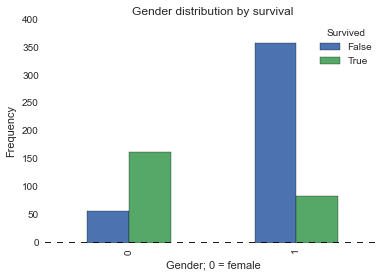

In [14]:
pd.crosstab(X_train.Gender, y_train.astype(bool)).plot(kind='bar')
plt.title('Gender distribution by survival')
plt.xlabel('Gender; 0 = female')
plt.ylabel('Frequency')

# Feature selection

In [15]:
from sklearn.feature_selection import SelectKBest, chi2

ch2 = SelectKBest(chi2, k = 4)
X_train2 = ch2.fit_transform(X_train, y_train)
# ch2.get_feature_names()
X_train2[0:10]


array([[  1.    ,   8.05  ,   0.    ,   0.    ],
       [  0.    ,  93.5   ,   0.    ,   0.    ],
       [  0.    ,  51.8625,   0.    ,   0.    ],
       [  1.    ,   6.2375,   0.    ,   0.    ],
       [  1.    ,  20.525 ,   0.    ,   0.    ],
       [  1.    ,   8.6625,   0.    ,   0.    ],
       [  1.    ,  35.5   ,   0.    ,   0.    ],
       [  1.    ,   7.225 ,   0.    ,   0.    ],
       [  1.    ,   7.7958,   0.    ,   0.    ],
       [  0.    ,   7.225 ,   0.    ,   0.    ]])

In [16]:
predictors = list(X_train.columns.values[ch2.get_support()])
print(predictors)

['Gender', 'FareFill', 'kidHighClass', 'momHighClass']


# Find logistic regression hyperparameters

In [17]:
def searchHyperparameters(X, y, param_grid, alg, cval = 10, score = 'accuracy'):
    
    # instantiate the grid
    grid = GridSearchCV(alg, param_grid, cv = cval, scoring = score)
    
    # fit the grid with data
    grid.fit(X, y)
    
    # view the complete results
    print("Best score:", grid.best_score_)
    print("Best parameters:", grid.best_params_)
    print("Best model:", grid.best_estimator_)
    
    # note if SD high, cross-val estimates may not be reliable
    results = grid.grid_scores_
    return results, grid

In [18]:
# Initialize our algorithm
alg = LogisticRegression()

In [19]:
# define parameter values to be searched
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
p_range = ['l1', 'l2']
param_grid = dict(C = c_range, penalty = p_range)
print(param_grid)

{'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


In [20]:
res, grid = searchHyperparameters(X_train[predictors], y_train, param_grid, alg, 10, 'roc_auc')

Best score: 0.837522587919
Best parameters: {'penalty': 'l2', 'C': 10}
Best model: LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [21]:
# Predict class for hold-out set.
holdout_pred = grid.predict(X_test[predictors])

# Model evaluation

In [22]:
def evaluation_metrics(ytest, ypred):
    
    # null accuracy
    null_accuracy = round(ytest.value_counts().max()/len(ytest), 3)
    print("Null accuracy:", null_accuracy)

    accuracy = round(accuracy_score(ytest, ypred), 3)
    print("Accuracy:", accuracy)
    
    confusion = confusion_matrix(ytest, ypred)
    print("Confusion matrix: actual(0,1) x predicted(0,1)\n", confusion)
    
    sensitivity = round(recall_score(ytest, ypred), 3)
    print("Sensitivity: when actual is positive, how often predicted positive", sensitivity)
    
    specificity = round(confusion[0,0]/(confusion[0,0] + confusion[0,1]), 3)
    print("Specificity: when actual is zero, how often predicted zero", specificity)

    precision = round(precision_score(ytest, ypred), 3)
    print("Precision: when predicted is positive, how often actual positive", precision)
    
    return accuracy, confusion, sensitivity, specificity, precision

In [23]:
def evaluate_prob(ytest, pred_prob):
    
    # histogram of probabilities
    plt.subplot(1, 2, 1)
    plt.hist(pred_prob, bins = 8)
    plt.xlim(0, 1)
    plt.title('Histogram of pred probabilities')
    plt.xlabel('Predicted probability of positive')
    plt.ylabel('Frequency')
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(ytest, pred_prob)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title("ROC curve")
    plt.xlabel("False positive rate (1 - specificity)")
    plt.ylabel("True positive rate (sensitivity)")
    plt.grid(True)
    
    plt.tight_layout() # adds more space between plots
    
    auc = round(roc_auc_score(y_test, predict_prob), 3)
    print("AUC score is:", auc)
    
    return fpr, tpr, thresholds, auc

In [24]:
# Use ROC curve to determine sensitivity & specificity for a given threshold
def evaluate_threshold(threshold):
    print("Sensitivity:", tpr[thresholds > threshold][-1])
    print("Specificity:", 1-fpr[thresholds > threshold][-1])

In [25]:
# Retrieve evaluation metrics
acc, conf, sens, spec, prec = evaluation_metrics(y_test, holdout_pred)

Null accuracy: 0.592
Accuracy: 0.78
Confusion matrix: actual(0,1) x predicted(0,1)
 [[105  27]
 [ 22  69]]
Sensitivity: when actual is positive, how often predicted positive 0.758
Specificity: when actual is zero, how often predicted zero 0.795
Precision: when predicted is positive, how often actual positive 0.719


In [27]:
# Predict probabilities for hold-out set
predict_prob = grid.predict_proba(X_test[predictors])[:,1]

AUC score is: 0.827


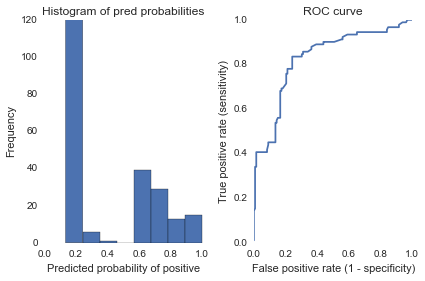

In [28]:
# Retrieve probability metrics
fpr, tpr, thresholds, auc = evaluate_prob(y_test, predict_prob)

In [29]:
# Determine class metrics for new threshold
# Note uses thresholds from histogram of probabilities, and so 0.5 does not exist
# Therefore, sensitivity is for thresholds > 0.5 (in this case 0.654)
evaluate_threshold(0.5)

Sensitivity: 0.758241758242
Specificity: 0.795454545455


In [30]:
# Determine class metrics for new threshold
evaluate_threshold(0.3)

Sensitivity: 0.78021978022
Specificity: 0.787878787879


In [31]:
# Change threshold for classification 
# One of the last steps in the model building process
from sklearn.preprocessing import binarize
y_pred_thresh = binarize(predict_prob, 0.3)[0]

C:\Users\Erin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [32]:
acc, conf, sens, spec, prec = evaluation_metrics(y_test, y_pred_thresh)

Null accuracy: 0.592
Accuracy: 0.785
Confusion matrix: actual(0,1) x predicted(0,1)
 [[104  28]
 [ 20  71]]
Sensitivity: when actual is positive, how often predicted positive 0.78
Specificity: when actual is zero, how often predicted zero 0.788
Precision: when predicted is positive, how often actual positive 0.717


In [80]:
y_pred_thresh[0:10]

array([ 1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.])

# Final step - submission

In [33]:
# Make predictions for test set.
test_pred = grid.predict(test[predictors])

In [35]:
test_predprob = grid.predict_proba(test[predictors])

In [38]:
test_predprob[10:20][:,1]

array([ 0.14492423,  0.17284261,  0.80544165,  0.17284261,  0.76436193,
        0.68780221,  0.15142493,  0.14396557,  0.63666921,  0.63479457])

In [34]:
test_pred[0:10]

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0], dtype=int64)

In [39]:
# Create a new dataframe with only the columns Kaggle wants from the dataset.
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": test_pred
    })

# Any files you save will be available in the output tab below
submission.to_csv('submission.csv', index=False)